## Degraded Broadcast Channel Demo

Author: Cheuk Ting Li  
Based on El Gamal and Kim, _Network Information Theory_, Ch. 5

In [1]:
from psitip import *
PsiOpts.setting(solver = "pyomo.glpk")  # Set linear programming solver
PsiOpts.setting(repr_latex = True)      # Turn on Jupyter Notebook LaTeX display
PsiOpts.setting(venn_latex = True)      # Turn on LaTeX in diagrams

In [2]:
X, Y, Z = rv("X, Y, Z")
M1, M2 = rv_array("M", 1, 3)
R1, R2 = real_array("R", 1, 3)

model = CodingModel()
model.set_rate(M1, R1)    # Rate of M1 is R1
model.set_rate(M2, R2)    # Rate of M2 is R2
model.add_node(M1+M2, X,
          label = "Enc")  # Encoder maps M1,M2 to X
model.add_edge(X, Y)      # Channel X -> Y -> Z
model.add_edge(Y, Z)
model.add_node(Y, M1,
        label = "Dec 1")  # Decoder 1 maps Y to M1
model.add_node(Z, M2,
        label = "Dec 2")  # Decoder 2 maps Z to M2

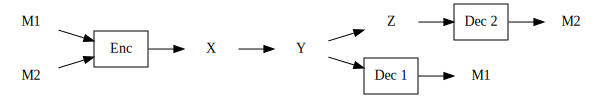

In [3]:
model.graph()             # Draw diagram

In [4]:
# Inner bound via [Lee-Chung 2015], give superposition region [Bergmans 1973], [Gallager 1974]
r = model.get_inner()
r

( ( R1 >= 0 )
 &( R2 >= 0 )
 &( R2 <= I(A_M2&Z) )
 &( R1+R2 <= I(A_M2&Z)+I(X&Y|A_M2) )
 &( markov(A_M2, X, Y, Z) ) ).exists(A_M2)

In [5]:
r.maximum(R1 + R2, [R1, R2])          # Max sum rate

(markov(Z, Y, X) ).maximum(I(X&Y))

In [6]:
r.maximum(emin(R1, R2), [R1, R2])     # Max symmetric rate

(( ( max17645(emin(R1, R2)) <= I(A_M2&Z) )
 &( 2*max17645(emin(R1, R2)) <= I(A_M2&Z)+I(X&Y|A_M2) )
 &( markov(A_M2, X, Y, Z) ) ).exists(A_M2)).maximum(max17645(emin(R1, R2)))

In [7]:
r.maximum(R1 / 2 + R2, [R1, R2])      # Max weighted sum rate

(( ( markov(A_M2, X, Y, Z) ) ).exists(A_M2)).maximum((I(A_M2&Z)+(1/2)*I(X&Y|A_M2)))

In [8]:
r.exists(R1)   # Eliminate R1, same as r.projected(R2)

( ( R2 >= 0 )
 &( R2 <= I(X&Z) )
 &( markov(Z, Y, X) ) )

In [9]:
# Eliminate Z, i.e., taking union of the region over all choices of Z
# The program correctly deduces that it suffices to consider Z = Y
r.exists(Z).simplified()

( ( R1 >= 0 )
 &( R2 >= 0 )
 &( R1+R2 <= I(X&Y) ) )

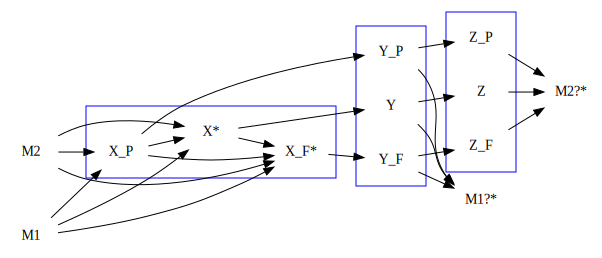

In [10]:
r_out = model.get_outer() # Automatic outer bound
model.graph_outer()       # Bayesian network of past/future variables

In [11]:
# Converse proof, print auxiliary random variables
(r_out >> r).check_getaux_array()

CompArray(
[[A_M2, Y_F+Z_P+Z_F+M2]])

### References
- P. Bergmans, "Random coding theorem for broadcast channels with degraded components," IEEE Transactions on Information Theory, vol. 19, no. 2, pp. 197–207, 1973.
- R. G. Gallager, "Capacity and coding for degraded broadcast channels," Problemy Peredachi Informatsii, vol. 10, no. 3, pp. 3–14, 1974.